# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t)
\end{align}
...with boundary conditions...
\begin{align}
    k(0) =& k_0 \\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to capital: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sympy as sym

import pycollocation

In [3]:
# define some variables
t, k, c, C, A, K, L, r  = sym.symbols("t, k, c, C, A, K, L, r")

In [4]:
# define some initial conditions
A0, L0 = sym.symbols("A0, L0")

# define some production parameters
alpha, delta = sym.symbols("alpha, delta")

# define growth rates
g, n = sym.symbols("g, n")

# define some preference parameters
theta, rho = sym.symbols("theta, rho")

In [5]:
# user defined extensive production function
def extensive_output(A, K, L, **params):
    """Output is a function of technology, A, capital, K, and labor, L."""
    alpha = params['alpha']
    return K**alpha * (A * L)**(1 - alpha)

def flow_utility(C, **params):
    """Flow utility from consumption (per capita)."""
    theta = params['theta']
    return (C**(1 - theta) - 1) / (1 - theta)

def steady_state_capital(A0, delta, g, n, rho, alpha, theta):
    """
    Equilibrium value of capital (per unit effective labor) with
    Cobb-Douglas production and Constant Relative Risk Aversion (CRRA)
    preferences.
    
    """
    return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))


In [33]:
class RamseyModelLike(object):

    def marginal_product_capital(A, K, L, **params):
        """Marginal product of labor."""
        Y = extensive_output(A, K, L, **params)
        return sym.diff(Y, K, 1)

    def marginal_product_labor(A, K, L, **params):
        """Marginal product of labor."""
        Y = extensive_output(A, K, L, **params)
        return sym.diff(Y, L, 1)

    def intensive_output(k, **params):
        """
        Intensive output is a function of capital (per unit effective labor)
        and model parameters.

        """
        return extensive_output(1, k, 1, **params) 

    def actual_investment(k, c, **params):
        """Return investment (per unit effective labor)."""
        return intensive_output(k, **params) - c

    def break_even_investment(k, delta, g, n, **params):
        """
        Return level of investment (per unit effective labor) required
        to maintain current level of capital (per unit effective labor).

        """
        return (g + n + delta) * k

    def equation_motion_capital(self, t, k, c, A0, delta, g, n, rho, **params):
        """Equation of motion for capital (per unit effective labor)."""
        k_dot = (actual_investment(k, c, **params) -
                 break_even_investment(k, delta, g, n, **params))
        return k_dot

    def equation_motion_consumption(self, t, k, c, A0, delta, g, n, rho, **params):
        """Equation of motion for consumption (per unit effective labor."""    
        # dependence on global variable C and r!
        C_growth_rate = consumption_euler_equation(C, r, rho, **params)
        temp = C_growth_rate.subs({C: A0 * sym.exp(g * t) * c,
                                   r: real_interest_rate(k, delta, **params)})
        c_dot = (temp - g) * c
        return c_dot

    def real_interest_rate(k, delta, **params):
        """Return the real interest rate (net depreciation)."""
        mpk = marginal_product_capital(1, k, 1, **params)
        r = mpk - delta
        return r

    def relative_risk_aversion_coef(C, **params):
        """Return the coefficient of relative risk aversion."""
        u = flow_utility(C, **params)
        crra = -((C * sym.diff(u, C, 2)) / sym.diff(u, C, 1))
        return crra

    def elasticity_intertemporal_substitution(C, **params):
        """
        Elasticity of intertemporal substitution is reciprical of the
        coefficient of relative risk aversion.

        """
        epsilon = 1 / relative_risk_aversion_coef(C, **params)
        return epsilon

    def consumption_euler_equation(C, r, rho, **params):
        """
        Representative household's consumption Euler equation.

        The Euler equation implies that the growth rate of per
        capita consumption is proportional to the difference
        between the real interest rate and the discount rate of
        the representative household.

        """
        epsilon = elasticity_intertemporal_substitution(C, **params)
        consumption_growth = epsilon * (r - rho)
        return consumption_growth

    def steady_state_capital_locus(k, delta, g, n, **params):
        """
        Locus of points (k, c) such that :math:`\dot{k}=0`.

        Function returns the level of consumption (per unit
        effective labor) required in order to maintain a given
        level of capital (per unit effective labor).

        """
        locus = (intensive_output(k, **params) -
                 break_even_investment(k, delta, g, n, **params))
        return locus

    def steady_state_consumption(self, A0, delta, g, n, rho, **params):
        """Equilibrium value for consumption (per unit effective labor)."""
        k_star = steady_state_capital(A0, delta, g, n, rho, **params)
        c_star = steady_state_capital_locus(k_star, delta, g, n, **params)
        return c_star


In [34]:
model = RamseyModelLike()

In [35]:
# create a dictionary representing the RHS of our model
k_dot = model.equation_motion_capital(t, k, c, A0, delta, g, n, rho,
                                      alpha=alpha, theta=theta)
c_dot = model.equation_motion_consumption(t, k, c, A0, delta, g, n, rho,
                                          alpha=alpha, theta=theta)
rhs = {'k': k_dot, 'c': c_dot}
print rhs

{'k': -c - k*(delta + g + n) + k**alpha, 'c': c*(-g + (A0*c*exp(g*t))**(-theta + 1)*(A0*c*exp(g*t))**(theta - 1)*(alpha*k**alpha/k - delta - rho)/theta)}


...next we do the same for consumption...

\begin{align}
    0 =& k^{*\alpha} - c^* - (g + n + \delta)k^* \\
    c^* =& k^{*\alpha} - (g + n + \delta)k^*
\end{align}

In [36]:
# finally we need to define some parameters...
params = {'A0': 1.0, 'alpha': 0.33, 'delta': 0.04, 'theta': 1.05, 'rho': 0.05,
          'g': 0.02, 'n': 0.02}

In [37]:
# call function with numeric inputs and get a numeric result!
model.steady_state_consumption(**params)

1.303501661180578

In [38]:
# define some boundary conditions
k0 = 1.0
c_star = steady_state_consumption(A0=A0, alpha=alpha, delta=delta,
                                  theta=theta, rho=rho, g=g, n=n)

bcs = {'lower': [k - k0],
       'upper': [c - c_star]}
print bcs

{'upper': [c + (alpha/(delta + g*theta + rho))**(1/(-alpha + 1))*(delta + g + n) - ((alpha/(delta + g*theta + rho))**(1/(-alpha + 1)))**alpha], 'lower': [k - 1.0]}


## Using pyCollocation

In [39]:
bvp = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                 independent_var='t',
                                                 rhs=rhs,
                                                 boundary_conditions=bcs,
                                                 params=params)

In [40]:
solver = pycollocation.OrthogonalPolynomialSolver(bvp)

In [42]:
# now this works for numerical values as well!
steady_state_capital(**params)

5.084580947867504

In [43]:
# define our domain of approximation
domain = [0.0, 100.0]

# initial guess for capital
N = 1000
ts = np.linspace(domain[0], domain[1], N)
ks = steady_state_capital(**params) - (steady_state_capital(**params) - k0) * np.exp(-ts)
cs = np.log(ks)

def initial_polynomial(ts, xs, deg, domain):
    """Eventually need some to link to underlying basis functions!"""
    return np.polynomial.Chebyshev.fit(ts, ks, deg, domain)

def initial_coefs(ts, ks, cs, deg, domain):
    """Return dictionary of coefs."""
    capital = initial_polynomial(ts, ks, deg, domain)
    consumption = initial_polynomial(ts, cs, deg, domain)
    coefs = {'k': capital.coef, 'c': consumption.coef}
    return coefs

In [44]:
coefs_guess = initial_coefs(ts, ks, cs, 35, domain) 
solver.solve(kind="Chebyshev",
             coefs_dict=coefs_guess,
             domain=domain)

In [45]:
solver.result.x

array([  4.37225405e+00,   1.29407760e+00,  -9.72862387e-01,
         6.08921292e-01,  -3.18201558e-01,   1.37285311e-01,
        -4.62850602e-02,   9.22882156e-03,   2.25265028e-03,
        -4.07400457e-03,   3.21212000e-03,  -2.07493833e-03,
         1.24105453e-03,  -7.22117266e-04,   4.18592261e-04,
        -2.44435831e-04,   1.44396564e-04,  -8.63551432e-05,
         5.22449115e-05,  -3.19390960e-05,   1.97071578e-05,
        -1.22605018e-05,   7.68428915e-06,  -4.84844391e-06,
         3.07792569e-06,  -1.96514557e-06,   1.26163055e-06,
        -8.14606070e-07,   5.29424467e-07,  -3.47071441e-07,
         2.30580740e-07,  -1.56776432e-07,   1.10978890e-07,
        -8.39515497e-08,   4.59631210e-08,  -9.06485047e-09,
         1.17873943e+00,   2.28498625e-01,  -1.76366595e-01,
         1.16303877e-01,  -6.68076608e-02,   3.42707361e-02,
        -1.62089828e-02,   7.36702585e-03,  -3.37782840e-03,
         1.63268450e-03,  -8.50106911e-04,   4.74261609e-04,
        -2.78167064e-04,

In [46]:
# now create a visualizer for plot the solution...
visualizer = pycollocation.Visualizer(solver)

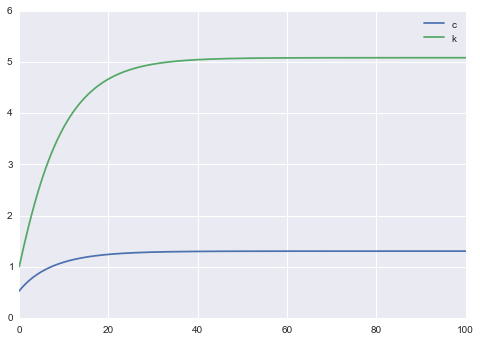

In [47]:
# plot the solution
visualizer.interpolation_knots = np.linspace(domain[0], domain[1], N)
visualizer.solution.plot()
plt.show()

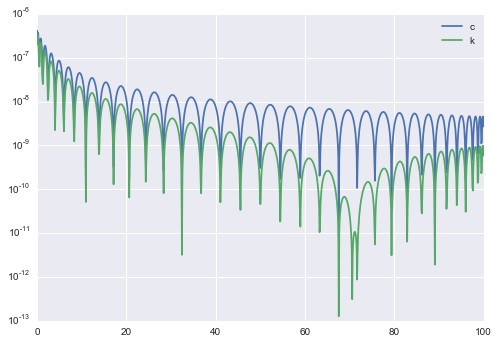

In [48]:
# plot the normalized residuals (they should be small everywhere!)
visualizer.normalized_residuals.plot(logy=True)
plt.show()